In this text we are implementing sweep rehearsal in Python using Keras framework

However, the main difference is that here the whole new data is given as training data while in the original paper, only one novel class was introduced at a time. Randomly chosen three classes were retrained for every epoch. But remember, it was for a setting where classes were added sequentially. Not the one that we are simulating here exactly.

# Importing MNIST and Fashion datasets

In [1]:
import keras
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

from keras import backend as K

img_rows, img_cols = 28, 28
batch_size = 1000
num_classes = 10
epochs = 1
colors = 1

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], colors, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], colors, img_rows, img_cols)
    input_shape = (colors, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, colors)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, colors)
    input_shape = (img_rows, img_cols, colors)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

pre_y_train = y_train
pre_y_test = y_test

y_test = keras.utils.to_categorical(y_test, 20)
y_train = keras.utils.to_categorical(y_train, 20)

import keras
from keras.datasets import fashion_mnist
import numpy as np

(x_train_h, y_train_h), (x_test_h, y_test_h) = fashion_mnist.load_data()

x_train_h = x_train_h/255
x_test_h = x_test_h/255

y_train_h = np.copy(y_train_h)
y_test_h = np.copy(y_test_h)

y_train_h += 10
y_test_h += 10

x_train_h = np.reshape(x_train_h,(60000,28,28,1))

pre_y_train_h = y_train_h
pre_y_test_h = y_test_h

y_test_h = keras.utils.to_categorical(y_test_h, 20)
y_train_h = keras.utils.to_categorical(y_train_h, 20)

Using TensorFlow backend.


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


# Creating a CNN as our base model

In [2]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, Activation, Dropout, MaxPooling2D

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:],name='conv_1'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3),name='conv_1b'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same',name='conv_1c'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3),name='conv_1d'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(20))
model.add(Activation('softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




# Training the model on MNIST Handwritten digits

In [3]:
history = model.fit(x_train,y_train,verbose=1,epochs=5,batch_size=100)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/5





60000/60000 [==============================] - 9s 150us/step - loss: 0.2391 - acc: 0.9257
Epoch 2/5
60000/60000 [==============================] - 6s 92us/step - loss: 0.0668 - acc: 0.9803
Epoch 3/5
60000/60000 [==============================] - 6s 93us/step - loss: 0.0479 - acc: 0.9845
Epoch 4/5
60000/60000 [==============================] - 6s 92us/step - loss: 0.0398 - acc: 0.9878
Epoch 5/5
60000/60000 [==============================] - 6s 93us/step - loss: 0.0328 - acc: 0.9899


In [0]:
original_weights = model.get_weights()

# Implementing sweep rehearsal

In [11]:
model.set_weights(original_weights)

import random

epochs = 30

old_task_retention=[]

for epoch_number in range(epochs):
  print(" ")
  print("Epoch number: ",epoch_number)
  
  model.fit(x_train_h,y_train_h,epochs=1,batch_size=100,verbose=1)
  
  # Implementing the sweep rehearsal here
  sweep_x_train = np.zeros((0,28,28,1))
  sweep_y_train = np.zeros((0,20))
  
  for i in range(3):
    random_number = random.choice(range(10))
    print("Generated random number is: ",random_number)
    sweep_x_train = np.vstack((sweep_x_train,x_train[np.where(pre_y_train==random_number)]))
    sweep_y_train = np.vstack((sweep_y_train,y_train[np.where(pre_y_train==random_number)]))

  print("Shape of data is: ",sweep_x_train.shape, sweep_y_train.shape)
  history_of_new_task = model.fit(sweep_x_train,sweep_y_train,validation_data=(x_test,y_test))
  old_task_retention.append(history_of_new_task.history["val_acc"])

 
Epoch number:  0
Epoch 1/1
60000/60000 [==============================] - 6s 97us/step - loss: 0.5281 - acc: 0.8142
Generated random number is:  3
Generated random number is:  3
Generated random number is:  1
Shape of data is:  (19004, 28, 28, 1) (19004, 20)
Train on 19004 samples, validate on 10000 samples
Epoch 1/1
19004/19004 [==============================] - 5s 238us/step - loss: 0.0076 - acc: 0.9979 - val_loss: 1.3555 - val_acc: 0.7239
 
Epoch number:  1
Epoch 1/1
60000/60000 [==============================] - 6s 97us/step - loss: 0.3276 - acc: 0.8806
Generated random number is:  9
Generated random number is:  6
Generated random number is:  1
Shape of data is:  (18609, 28, 28, 1) (18609, 20)
Train on 18609 samples, validate on 10000 samples
Epoch 1/1
18609/18609 [==============================] - 5s 245us/step - loss: 0.0179 - acc: 0.9960 - val_loss: 1.1601 - val_acc: 0.7044
 
Epoch number:  2
Epoch 1/1
60000/60000 [==============================] - 6s 96us/step - loss: 0.2852 

In [12]:
x_test_h = np.reshape(x_test_h,(10000,28,28,1))
print("Accuracy on Fashion: ",model.evaluate(x_test_h,y_test_h)[1]*100)

10000/10000 [==============================] - 1s 61us/step
Accuracy on Fashion:  90.94


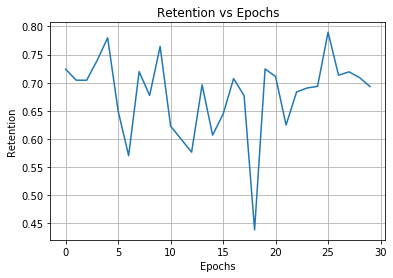

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(30),old_task_retention)
plt.grid()
plt.xlabel("Epochs")
plt.ylabel("Retention")
plt.title("Retention vs Epochs")
plt.show()